In [1]:
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# for plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from gensim.models.phrases import Phrases, Phraser

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\users\user\appdata\local\programs\python\python39\lib

## Load dataset 

Завантаження даних з датасету, беремо поки не всі дані, оскільки це займе багато часу

In [2]:
emails = pd.read_csv('emails.csv')
#email_subset = emails[:10000]
email_subset = emails.sample(frac=0.2, random_state=1)

print(email_subset.shape)
email_subset.head()

(103480, 2)


,file,message
186822,jones-t/all_documents/634.,Message-ID: <17820178.1075846925335.JavaMail.e...
308790,mann-k/all_documents/5690.,Message-ID: <29110382.1075845717882.JavaMail.e...
82383,dasovich-j/sent/423.,Message-ID: <6812040.1075843194135.JavaMail.ev...
227299,kaminski-v/var/63.,Message-ID: <21547648.1075856642126.JavaMail.e...
301824,mann-k/_sent_mail/3208.,Message-ID: <12684200.1075846107179.JavaMail.e...


Дані потрібно привести до потібного вигляду, очистити початок повідомлення,
взяти з повідомлення адерс відправника та отримувача.

In [3]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in tqdm(messages, desc="Parse raw message: ")]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [4]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))
email_df.head()

Parse raw message: 100%|████████████████████████████████████████████████████| 103480/103480 [00:06<00:00, 14827.12it/s]


,body,to,from_
0,"It would be nice if you could be at my dinner,...",alicia.goodrow@enron.com,tana.jones@enron.com
1,Absolutely.Good point! Can Peter start to dra...,Kay Mann/Corp/Enron@ENRON,Sheila Tweed@ECT on 05/15/2001 06
2,My apologies. My schedule melted down after w...,christine.piesco@oracle.com,jeff.dasovich@enron.com
3,"Vince,UK VAR breached the limit last week.UK t...","Richard Lewis/LON/ECT@ECT, James New/LON/ECT@E...",tanya.tamarchenko@enron.com
4,Any problems/comments?AM ---------------------...,"Don Hammond/PDX/ECT@ECT, Jody Blackburn/PDX/EC...",kay.mann@enron.com


## Preproces data

In [5]:
# Convert email body to list
data = email_df.body.values.tolist()

In [6]:
# tokenize - break down each sentence into a list of words
def sent_to_words(sentences):
    for sentence in tqdm(sentences, desc="Sentence to words: "):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

Sentence to words: 100%|█████████████████████████████████████████████████████| 103480/103480 [00:48<00:00, 2119.79it/s]


In [8]:
data_words[8]

['dporter',
 'enron',
 'com',
 'eric',
 'linder',
 'enron',
 'com',
 'geir',
 'solberg',
 'enron',
 'com',
 'greg',
 'wolfe',
 'enron',
 'com',
 'holden',
 'salisbury',
 'enron',
 'com',
 'jbryson',
 'enron',
 'com',
 'leaf',
 'harasin',
 'enron',
 'com',
 'monika',
 'causholli',
 'enron',
 'com',
 'mark',
 'guzman',
 'enron',
 'com',
 'pete',
 'davis',
 'enron',
 'com',
 'ryan',
 'slinger',
 'enron',
 'comdporter',
 'enron',
 'com',
 'eric',
 'linder',
 'enron',
 'com',
 'geir',
 'solberg',
 'enron',
 'com',
 'greg',
 'wolfe',
 'enron',
 'com',
 'holden',
 'salisbury',
 'enron',
 'com',
 'jbryson',
 'enron',
 'com',
 'leaf',
 'harasin',
 'enron',
 'com',
 'monika',
 'causholli',
 'enron',
 'com',
 'mark',
 'guzman',
 'enron',
 'com',
 'pete',
 'davis',
 'enron',
 'com',
 'ryan',
 'slinger',
 'enron',
 'comvariances',
 'detected',
 'variances',
 'detected',
 'in',
 'generation',
 'schedule',
 'schedules',
 'txt',
 'generation',
 'schedule',
 'variance',
 'found',
 'in',
 'table',
 'tbl

In [9]:
# Build the bigram and trigram models
# min_count – ігнорувати всі слова та біграми, загальна кількість зібраних даних яких менша за це значення.
# threshold представляє поріг для формування фраз (більше означає менше фраз). Фраза зі слів a і b приймається, якщо (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > порогове значення, де N – загальний обсяг словника. За замовчуванням його значення становить 10,0
print("Make bigram...")
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = Phraser(bigram)

print("Make trigram...")
trigram = Phrases(bigram[data_words], threshold=100)
trigram_mod = Phraser(trigram)

Make bigram...
Make trigram...


In [10]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[200]]])

['image_image', 'image', 'getting', 'together', 'for', 'the', 'holidays', 'is', 'something', 'we', 'all', 'enjoy', 'whether', 'it', 'gathering', 'with', 'old', 'friends', 'from', 'out', 'of', 'town', 'or', 'hanging', 'out', 'with', 'the', 'usual', 'gang', 'every', 'gathering', 'this', 'time', 'of', 'year', 'seems', 'little', 'more', 'special', 'we', 'at', 'miller_brewing', 'wish', 'you', 'many', 'happy', 'celebrations', 'this', 'season', 'and', 'thank', 'you', 'for', 'enjoying', 'those', 'occasions', 'responsibly', 'happy_holidays', 'image', 'this', 'mail', 'is', 'not', 'sent_unsolicited', 'you', 'subscribed', 'to', 'receive', 'information', 'from', 'miller_brewing', 'at', 'miller', 'web_site', 'or', 'event', 'must', 'be', 'or', 'older', 'to', 'visit', 'our', 'web_site', 'miller_brewing', 'co', 'milwaukee_wi', 'miller_brewing', 'company', 'milwaukee_wi', 'privacy_statement', 'image_image_image_image', 'this', 'message', 'was', 'sent', 'by', 'miller_brewing', 'company', 'using_responsys

In [11]:
# prep NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

# remove stop_words, make bigrams and lemmatize
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tqdm(texts, desc="Remove stop words: ")]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in tqdm(texts, desc="Make bigrams: ")]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in tqdm(texts, desc="Make trigrams: ")]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tqdm(texts, desc="Lematization: "):
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

Lematization: 100%|████████████████████████████████████████████████████████████| 103480/103480 [35:01<00:00, 49.23it/s]


## Analysis

In [15]:
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
def flatten(l):
    return [item for sublist in l for item in sublist]

### Words before preproces

In [64]:
words_on_start = flatten(data_words)[:200_000]
text_to_cloud_onstart = ' '.join(words_on_start)

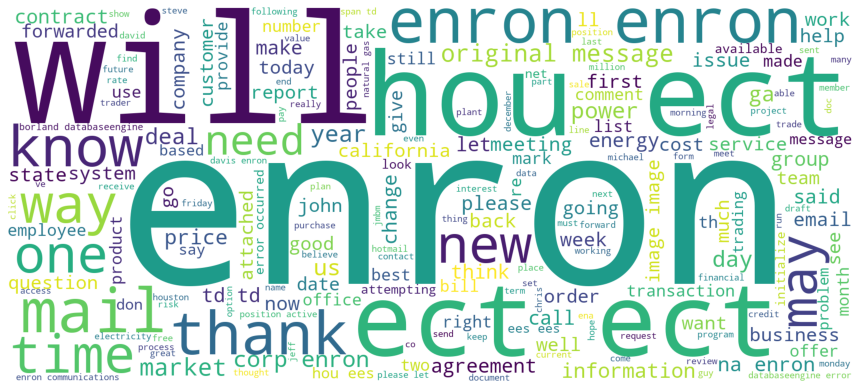

In [65]:
wordcloud=WordCloud(width=1800, height =800, background_color="white", min_font_size=5, random_state=42).generate(text_to_cloud_onstart)
plt.figure(figsize=(18,8), facecolor = None )
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad=10)
plt.show()

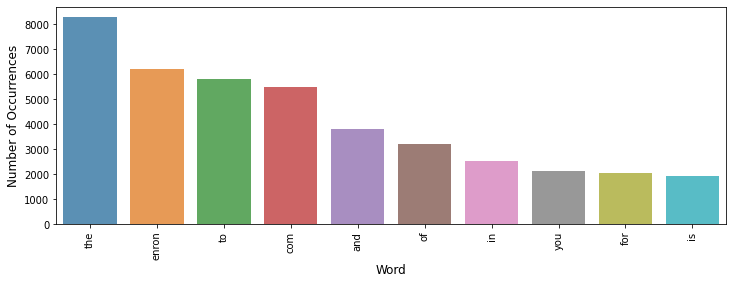

In [66]:
counted_words = Counter(words_on_start)
counted_df = pd.DataFrame(counted_words.items(), columns=['word', 'count']).sort_values('count', ascending=False).reset_index(drop=True) #create new df from counter

plt.figure(figsize=(12,4))
sns.barplot(data=counted_df[:10], x='word', y='count', alpha=0.8) #plot only the top 10 by slicing the df
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Words after delete stop word

In [57]:
words_nonstops = flatten(data_words_nostops)[:200_000]
text_to_cloud_nonstop = ' '.join(words_nonstops)

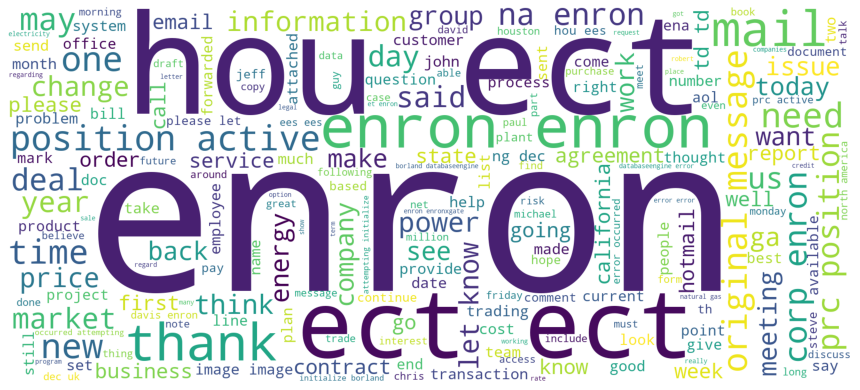

In [58]:
wordcloud=WordCloud(width=1800, height =800, background_color="white", min_font_size=5, random_state=42).generate(text_to_cloud_nonstop)
plt.figure(figsize=(18,8), facecolor = None )
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad=10)
plt.show()

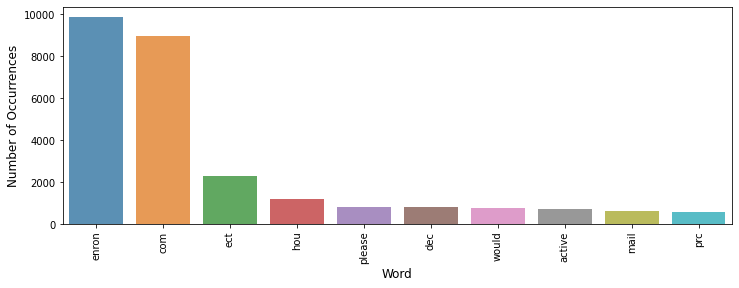

In [59]:
counted_words = Counter(words_nonstops)
counted_df = pd.DataFrame(counted_words.items(), columns=['word', 'count']).sort_values('count', ascending=False).reset_index(drop=True) #create new df from counter

plt.figure(figsize=(12,4))
sns.barplot(data=counted_df[:10], x='word', y='count', alpha=0.8) #plot only the top 10 by slicing the df
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [86]:
list_count_without_stop_word = []
for el in data_words_nostops:
    list_count_without_stop_word.append(len(el))
    
list_count = []
for el in data_words:
    list_count.append(len(el))

In [87]:
list_count[:10]
import statistics

In [96]:
print("                                   Перед видаленням стоп-слів        Після видалення стоп-слів")
print("Середня довжина електроного листа:    "+f"       {round(sum(list_count) / len(list_count),2)}" +"                             "+f"{round(sum(list_count_without_stop_word) / len(list_count_without_stop_word),2)}")
print("Максимальна довжина електроного листа:"+f"       {max(list_count)}" +"                              "+f"{max(list_count_without_stop_word)}")

                                   Перед видаленням стоп-слів        Після видалення стоп-слів
Середня довжина електроного листа:           222.39                             149.97
Максимальна довжина електроного листа:       66445                              66036


### Words after lemmatized

In [60]:
words_after_lemmatized = flatten(data_lemmatized)[:200_000]

In [61]:
text_to_cloud = ' '.join(words_after_lemmatized)

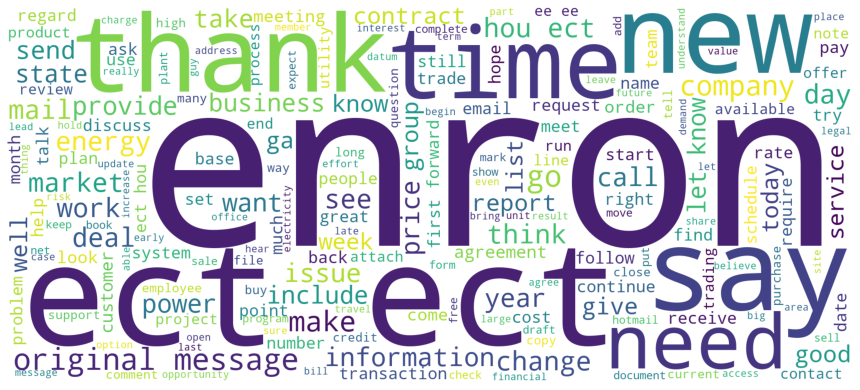

In [62]:
from wordcloud import WordCloud
wordcloud=WordCloud(width=1800, height =800, background_color="white", min_font_size=5, random_state=42).generate(text_to_cloud)
plt.figure(figsize=(18,8), facecolor = None )
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad=10)
plt.show()

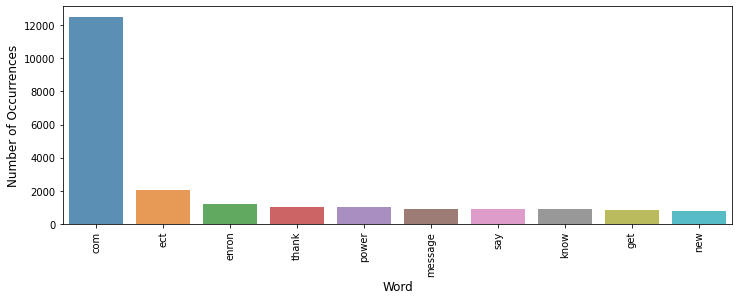

In [63]:
counted_words = Counter(words_after_lemmatized)
counted_df = pd.DataFrame(counted_words.items(), columns=['word', 'count']).sort_values('count', ascending=False).reset_index(drop=True) #create new df from counter

plt.figure(figsize=(12,4))
sns.barplot(data=counted_df[:10], x='word', y='count', alpha=0.8) #plot only the top 10 by slicing the df
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [15]:
print(data_words_bigrams[15])

['killed', 'changed', 'apb', 'changed', 'apb', 'kept', 'hope', 'makes_sense', 'trading', 'much', 'today', 'guys', 'arescrewing', 'left', 'right', 'kateamerex', 'brokered', 'trade', 'put', 'option', 'enron', 'buys', 'powerex', 'strike', 'price', 'amerex', 'buys', 'williams', 'amerex', 'buys', 'puget', 'might', 'duponly', 'one', 'deal', 'done', 'amerex', 'said']


In [16]:
print(data_lemmatized[15])

['kill', 'change', 'apb', 'change', 'apb', 'keep', 'hope', 'makes_sense', 'trading', 'much', 'today', 'guy', 'arescrewe', 'leave', 'right', 'broker', 'trade', 'put', 'option', 'buy', 'strike', 'price', 'buy', 'buy', 'puget', 'duponly', 'deal', 'do', 'say']


In [17]:
for before, after in zip(data_words_bigrams[15][:15], data_lemmatized[15][:15]):
    print(f'{before} -> {after}')

killed -> kill
changed -> change
apb -> apb
changed -> change
apb -> apb
kept -> keep
hope -> hope
makes_sense -> makes_sense
trading -> trading
much -> much
today -> today
guys -> guy
arescrewing -> arescrewe
left -> leave
right -> right


In [18]:
# create dictionary and corpus both are needed for (LDA) topic modeling

# Create Dictionary
id2word = corpora.Dictionary(tqdm(data_lemmatized, desc="Create dictionary: "))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm(texts, desc="Term document Frequency: ")]


Term document Frequency: 100%|██████████████████████████████████████████████| 103480/103480 [00:06<00:00, 15240.90it/s]


In [19]:
for before, after in zip(data_lemmatized[15][:15], corpus[15][:15]):
    print(f'{before} -> {after}')

kill -> (95, 2)
change -> (111, 1)
apb -> (156, 1)
change -> (182, 1)
apb -> (192, 1)
keep -> (241, 1)
hope -> (283, 1)
makes_sense -> (314, 3)
trading -> (373, 1)
much -> (403, 1)
today -> (441, 1)
guy -> (470, 1)
arescrewe -> (548, 1)
leave -> (588, 1)
right -> (633, 2)


In [20]:
from collections.abc import Iterable
isinstance(id2word, Iterable)

True

## Train model

### LSA

In [45]:
from gensim.models import LsiModel

In [100]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_UMass(corpus, dictionary, k, i):
    lsi_model = LsiModel(corpus=corpus, num_topics=k, power_iters=i)
    coherence = CoherenceModel(model=lsi_model,
                              texts=data_lemmatized,
                              dictionary=dictionary,
                              coherence='c_v')
    return lsi_model, coherence.get_coherence()

coherenceList_UMass = {}
limit=40; start=2; step=6;
x = list(range(start, limit, step))
numTopicsList = x + [100]

power_iters = [2,4,6,10]

for k in numTopicsList:
    for i in power_iters:
        print(f'numTopics: {k}, power_iters: {i}')
        model, c_UMass = compute_coherence_UMass(corpus, id2word, k, i)
        coherenceList_UMass[model] = [k,i,c_UMass]

numTopics: 2, power_iters: 2
numTopics: 2, power_iters: 4
numTopics: 2, power_iters: 6
numTopics: 2, power_iters: 10
numTopics: 8, power_iters: 2
numTopics: 8, power_iters: 4
numTopics: 8, power_iters: 6
numTopics: 8, power_iters: 10
numTopics: 14, power_iters: 2
numTopics: 14, power_iters: 4
numTopics: 14, power_iters: 6
numTopics: 14, power_iters: 10
numTopics: 20, power_iters: 2
numTopics: 20, power_iters: 4
numTopics: 20, power_iters: 6
numTopics: 20, power_iters: 10
numTopics: 26, power_iters: 2
numTopics: 26, power_iters: 4
numTopics: 26, power_iters: 6
numTopics: 26, power_iters: 10
numTopics: 32, power_iters: 2
numTopics: 32, power_iters: 4
numTopics: 32, power_iters: 6
numTopics: 32, power_iters: 10
numTopics: 38, power_iters: 2
numTopics: 38, power_iters: 4
numTopics: 38, power_iters: 6
numTopics: 38, power_iters: 10
numTopics: 100, power_iters: 2
numTopics: 100, power_iters: 4
numTopics: 100, power_iters: 6
numTopics: 100, power_iters: 10


In [47]:
lsi_model = LsiModel(corpus=corpus, num_topics=14, power_iters=10)
coherence = CoherenceModel(model=lsi_model,
                              texts=data_lemmatized,
                              dictionary=id2word,
                              coherence='c_v')
coherence.get_coherence()

0.5049063907603185

In [48]:
coherence = CoherenceModel(model=lsi_model,
                              texts=data_lemmatized,
                              dictionary=id2word,
                              coherence='u_mass')
coherence.get_coherence()

-1.8851671644823216

In [108]:
lsa_coh_2, lsa_coh_4, lsa_coh_6, lsa_coh_10 = [], [], [], []

for model, val in coherenceList_UMass.items():
    if val[1] == 2:
        lsa_coh_2.append(val[2])
    if val[1] == 4:
        lsa_coh_4.append(val[2])
    if val[1] == 6:
        lsa_coh_6.append(val[2])
    if val[1] == 10:
        lsa_coh_10.append(val[2])

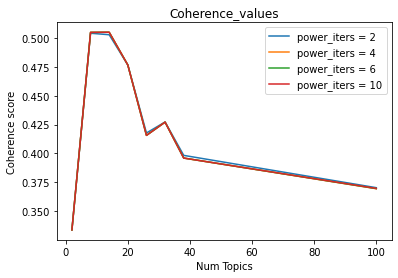

In [126]:
# Show graph
limit=40; start=2; step=6;
x = list(range(start, limit, step))+[100]
plt.plot(x, lsa_coh_2)
plt.plot(x, lsa_coh_4)
plt.plot(x, lsa_coh_6)
plt.plot(x, lsa_coh_10)
plt.legend(['power_iters = 2', 'power_iters = 4', 'power_iters = 6', 'power_iters = 10'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence_values")
plt.show()

In [123]:
model.print_topics()[0]

(0,
 '0.992*"323" + 0.096*"556" + 0.027*"441" + 0.022*"164" + 0.022*"354" + 0.021*"190" + 0.020*"457" + 0.012*"325" + 0.011*"192" + 0.010*"119"')

### LDA

In [36]:
# topic modeling
# corpus, dictionary and number of topics required for LDA
# alpha and eta are hyperparameters that affect sparsity of the topics
# chunksize is the number of documents to be used in each training chunk
# update_every determines how often the model parameters should be updated
# passes is the total number of training passes
# Print the Keyword in the 10 topics

In [127]:
from gensim.models.callbacks import PerplexityMetric
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')

In [ ]:
model_lda = {}
# Build LDA model
def lda_model(num_topics, passes, iterations):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=passes,
                                                iterations = iterations,
                                               alpha='auto',
                                               per_word_topics=True,
                                               callbacks=[perplexity_logger])
    return lda_model
    

limit=40; start=2; step=6;
x = list(range(start, limit, step))
numTopicsList = x + [100]
iterations = [50, 75, 100]

for n_t in numTopicsList:
    for p in passesList:
        for i in iterations:
            print(f"num_topics: {n_t}, iteratons: {i}")
            model = lda_model(n_t, p, i)
            model_lda[model] = [n_t, p, i]
    

In [38]:
doc_lda = lda_model[corpus]

In [39]:
# Model perplexity and topic coherence provide a convenient
# measure to judge how good a given topic model is.
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  -14.892537008442641


In [40]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.4321313676682097


In [41]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = gensimvis.prepare(lda_model, corpus, id2word)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [43]:
# now using mallet

In [20]:
mallet_path = 'E:\\Курс 5\\Семестер 1\\Проект\\mallet-2.0.8\\bin\\mallet'

In [21]:
import os
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet'
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [23]:
def compute_coherence_values(dictionary, corpus,texts, num_topics, iterations):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics,iterations = iterations, id2word=id2word)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')

    return model, coherencemodel.get_coherence()

In [ ]:
#model_lda = {}
limit=40; start=32; step=6;
x = list(range(start, limit, step))
numTopicsList = [100]
iterations = [50, 75, 100]

for n_t in numTopicsList:
    for i in iterations:
        print(f"num_topics: {n_t}, iteratons: {i}")
        model, cor = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
                                              num_topics = n_t, iterations = i)
        model_lda[model] = [n_t, i, cor]

In [53]:
coherence = CoherenceModel(model= lda_model_,
                              texts=data_lemmatized,
                              dictionary=id2word,
                              coherence='u_mass')
coherence.get_coherence()

-2.2658444433888176

In [39]:
lda_coh_50, lda_coh_75, lda_coh_100 = [], [], []

for model, val in model_lda.items():
    if val[1] == 50 and val[0] != 26 and val[0] != 38 and val[0] != 100 :
        lda_coh_50.append(val[2])
    if val[1] == 75 and val[0] != 26:
        lda_coh_75.append(val[2])
    if val[1] == 100:
        lda_coh_100.append(val[2])

In [41]:
len(lda_coh_50)

5

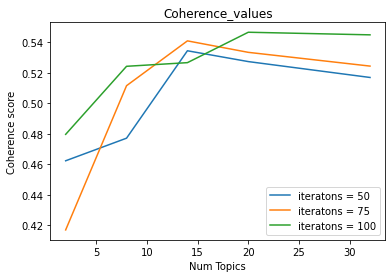

In [42]:
# Show graph
limit=40; start=2; step=6;
x = [2,8, 14, 20, 32]
plt.plot(x, lda_coh_50)
plt.plot(x, lda_coh_75)
plt.plot(x, lda_coh_100)
plt.legend(['iteratons = 50', 'iteratons = 75', 'iteratons = 100'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence_values")
plt.show()

In [55]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5251575605951304


In [56]:
# # Visualize the topics with mallet model
# pyLDAvis.enable_notebook(sort=True)
# vis = pyLDAvis.gensim.prepare(ldamallet, corpus, id2word)
# pyLDAvis.display(vis)

In [54]:
# Show Topics
print(lda_model_.show_topics(formatted=False))

[(16, [('power', 0.05060915190891982), ('energy', 0.032444321786490926), ('gas', 0.023859003943527097), ('plant', 0.017817360829404216), ('price', 0.017577956149042714), ('market', 0.015163958955397579), ('supply', 0.011350109394638664), ('high', 0.00984219241486171), ('year', 0.009521323641877199), ('electricity', 0.009514673511867158)]), (11, [('information', 0.01877440441678254), ('image', 0.0184639776697983), ('email', 0.016560369023002366), ('click', 0.01631664554396515), ('image_image', 0.01627559737907467), ('access', 0.014243713216995992), ('free', 0.013645949315778401), ('receive', 0.010808494917724084), ('page', 0.01016198632069905), ('link', 0.009174264853021915)]), (18, [('business', 0.028003266459202366), ('group', 0.02003796155289236), ('team', 0.015456090401465493), ('management', 0.014085501776688958), ('work', 0.012421373237105212), ('employee', 0.012280120947273168), ('support', 0.011982166898408704), ('continue', 0.011558410028912579), ('report', 0.011061819947471805

In [61]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(22, '0.078*"deal" + 0.054*"change" + 0.034*"draft" + 0.033*"review" + 0.031*"comment" + 0.025*"schedule" + 0.022*"attach" + 0.020*"send" + 0.017*"confirm" + 0.015*"forward"'), (1, '0.022*"issue" + 0.017*"cost" + 0.014*"model" + 0.014*"understand" + 0.013*"work" + 0.013*"time" + 0.012*"risk" + 0.011*"forward" + 0.010*"discuss" + 0.010*"point"'), (23, '0.024*"table" + 0.016*"end" + 0.016*"center" + 0.014*"size" + 0.013*"font" + 0.013*"top" + 0.012*"br" + 0.011*"good" + 0.011*"leave" + 0.009*"class"'), (21, '0.057*"agreement" + 0.027*"contract" + 0.013*"form" + 0.012*"option" + 0.012*"section" + 0.012*"payment" + 0.011*"provide" + 0.011*"language" + 0.010*"amount" + 0.010*"include"'), (13, '0.141*"mail" + 0.026*"energy" + 0.022*"bill" + 0.016*"make" + 0.016*"enron" + 0.014*"tax" + 0.012*"net" + 0.012*"pay" + 0.009*"fund" + 0.008*"today"'), (4, '0.052*"question" + 0.050*"send" + 0.044*"attach" + 0.033*"regard" + 0.032*"document" + 0.028*"call" + 0.028*"forward" + 0.028*"email" + 0.026*"c

In [59]:
def format_topics_sentences(ldamodel=lda_model_, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_, corpus=corpus, texts=data)

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [65]:
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16,0.1230,"work, call, good, time, talk, give, hope, toda...","It would be nice if you could be at my dinner,..."
1,1,21,0.1152,"agreement, contract, form, option, section, pa...",Absolutely.Good point! Can Peter start to dra...
2,2,16,0.1091,"work, call, good, time, talk, give, hope, toda...",My apologies. My schedule melted down after w...
3,3,1,0.4393,"issue, cost, model, understand, work, time, ri...","Vince,UK VAR breached the limit last week.UK t..."
4,4,21,0.1721,"agreement, contract, form, option, section, pa...",Any problems/comments?AM ---------------------...
5,5,20,0.4963,"power, energy, state, utility, electricity, pr...",I certainly agree on the tip of the iceberg po...
6,6,24,0.0551,"meeting, employee, program, conference, attend...",Kim can you also invite Mike Roberts.
7,7,7,0.2537,"travel, offer, rate, special, include, purchas...",==============================================...
8,8,14,0.2418,"ect, enron, hou, enronxgate, lon, forward, mic...","dporter3@enron.com, eric.linder@enron.com, gei..."
9,9,16,0.0489,"work, call, good, time, talk, give, hope, toda...",you still at school? call me at work.


In [66]:
df_dominant_topic.Keywords.iloc[1]

'agreement, contract, form, option, section, payment, provide, language, amount, include'

In [67]:
df_dominant_topic.Text.iloc[1]

'Absolutely.Good point!  Can Peter start to draft an override letter?Kay Mann@ENRONDieball/ENRON_DEVELOPMENT@ENRON_DEVELOPMENt, John GRigby/ENRON_DEVELOPMENT@ENRON_DEVELOPMENTAs a reminder to all of us, we will need a form override letter to go withthe form turbine contract.Kay'

In [68]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [69]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [70]:
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [71]:
# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.7389,"transaction, credit, trade, product, trading, ...",Deliverable Warehouse Receipts as Margin...=20...
1,1,0.5585,"issue, cost, model, understand, work, time, ri...","Julie,The introduction looks fine. I have made..."
2,2,0.9398,"company, service, technology, internet, busine...",==============================================...
3,3,0.9626,"person, pm, omni_publicaccess, cn_ddutch, meet...",<OMNI><OMNINotes></OMNINotes><OMNIPAB>PERSON~~...
4,4,0.8441,"question, send, attach, regard, document, call...","abilla@haas.berkeley.edu, ahan@haas.berkeley.e..."
5,5,0.8464,"high, day, close, week, market, low, expect, w...",-12.00F R I D A Y E X T R E M E M A R K E ...
6,6,0.6278,"state, policy, court, law, case, issue, govern...","version, please send an e-mail to lyris@lists...."
7,7,0.8530,"travel, offer, rate, special, include, purchas...",==============================================...
8,8,0.7511,"company, stock, share, year, market, business,...","Dow Jones News Service, 11/26/01Dynegy Board S..."
9,9,0.7844,"gas, price, day, capacity, month, volume, pipe...","mark.taylor@enron.com, jeff.blumenthal@enron.c..."


In [66]:
import gensim    
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_)

In [72]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
p

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.208306  0.064334       1        1  11.950411
16     0.219529  0.006566       2        1   7.275850
13     0.171160 -0.107830       3        1   7.241373
1      0.194792 -0.031677       4        1   5.721397
5      0.034874  0.248537       5        1   5.655349
18     0.176038 -0.064534       6        1   5.293327
9      0.165743 -0.089958       7        1   5.208480
10    -0.002823  0.105505       8        1   4.779895
11     0.017546  0.028217       9        1   4.645162
3      0.091662 -0.157657      10        1   4.445333
2     -0.058144  0.288795      11        1   4.439613
7     -0.212782 -0.099912      12        1   4.406632
19    -0.082035 -0.222025      13        1   4.167495
4      0.011666  0.086966      14        1   4.070898
12    -0.089295 -0.062354      15        1   3.742114
15    -0.230433 -0.104249      16        1   3.624208
17    -0.110823 -0.086240      17        1   3.561783
6     -0.227371  0.186168      18        1   3.417010
14    -0.034872  0.114883      19        1   3.241793
0     -0.242737 -0.103537      20        1   3.111875, topic_info=          Term          Freq         Total Category  logprob  loglift
119        ect  97511.000000  97511.000000  Default  30.0000  30.0000
556      enron  94420.000000  94420.000000  Default  29.0000  29.0000
514    message  51336.000000  51336.000000  Default  28.0000  28.0000
183   original  37024.000000  37024.000000  Default  27.0000  27.0000
142        hou  30917.000000  30917.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
317       call    549.588871  38365.894338  Topic20  -6.3130  -0.7758
2746      memo    427.885042   2492.618271  Topic20  -6.5633   1.7077
893       mark    456.069087  12484.564537  Topic20  -6.4995   0.1603
58        team    427.885042  13743.172532  Topic20  -6.5633   0.0005
1035      make    430.447228  43027.749501  Topic20  -6.5573  -1.1348

[1978 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
667         2  0.041586            _
667         8  0.001124            _
667        14  0.957598            _
14244      15  1.001307  abandonment
206786     15  0.998923   absbawc_aa
...       ...       ...          ...
2625        5  0.833624        young
2625       18  0.028549        young
2625       19  0.066070        young
13571      13  1.004535  youreceived
13412       7  0.998303        zonal

[4752 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 17, 14, 2, 6, 19, 10, 11, 12, 4, 3, 8, 20, 5, 13, 16, 18, 7, 15, 1])